# Práctica 2: Clasificación multi-instancia

## **Objetivo**: El objetivo de esta práctica es introducir los conceptos de clasificación multi-instancia

La práctica se ha realizado siguiendo la opción siguiente:

**OPCIÓN 2: Comparación de métodos**

Seleccione al menos dos algoritmos de los disponibles en la bibliotecas indicadas. Seleccione al menos tres problemas
semi-supervisados de los repositorios indicados.
Realice las siguientes tareas:
1. Aplique los algoritmos seleccionados a los datasets
2. Compare los resultados y explique qué conclusiones se podrían obtener

### Librerías

En las diapositivas del tema se han facilitado 3 librerías para realizar la práctica con python:
- [MISVM](https://github.com/garydoranjr/misvm)
- [MIL: multiple instance learning library for Python](https://github.com/rosasalberto/mil)
- [MILpy: Multiple-Instance Learning Python Toolbox](https://github.com/jmarrietar/MILpy)

Tras leer la documentación de las 3 librerías se ha optado por usar la segunda opción [MIL: multiple instance learning library for Python](https://github.com/rosasalberto/mil). La primera opción parece no tener el repositorio lo suficientemente bien documentado como para facilitar su uso, además, en el README.md viene indicado que aún está en desarrollo, sin embargo, no tiene aportaciones desde hace 8 años. La tercera opción es la más agregada a favoritos en github, sin embargo según la documentación sólo tiene implementados algoritmos y la mayoría basados en SVM. Por comodidad entonces, se ha decidido hacer uso del segundo repositorio, que ya tiene incluídas funciones de importar conjuntos de datos, de algoritmos y de predicción.

In [3]:
# Importar las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
import mil
from mil.data.datasets import birds_brown_creeper, corel_dogs, elephant

In [4]:
# Establecer semilla para reproducibilidad
SEED = 751
np.random.seed(SEED)

rng = np.random.RandomState(SEED)

### Preparación de datos

Se van a utilizar datasets de la página web proporcionada en las diapositivas del tema: [Multiple Instance Learning](http://www.multipleinstancelearning.com/datasets/). Se ha decidido esta opción ya que todos los conjuntos de datos se encuentran en formato CSV, lo que hace que sean más fáciles de importar en python para su posterior procesamiento. En concreto se han elegido los conjuntos de datos:
- *BrownCreeper*
- *Elephants*
- *CorelDogs*

Que además, ya vienen incluídos en la librería seleccionada.

In [5]:
# Dataset Brown Creeper
(bagsBrownCreeper_train, yBrownCreeper_train), (bagsBrownCreeper_test, yBrownCreeper_test) = birds_brown_creeper.load()

# Dataset Elephants
(bagsElephant_train, yElephant_train), (bagsElephant_test, yElephant_test) = elephant.load()

# Dataset Corel Dogs
(bagsCorelDogs_train, yCorelDogs_train), (bagsCorelDogs_test, yCorelDogs_test) = corel_dogs.load()

Vamos a visualizar los datasets

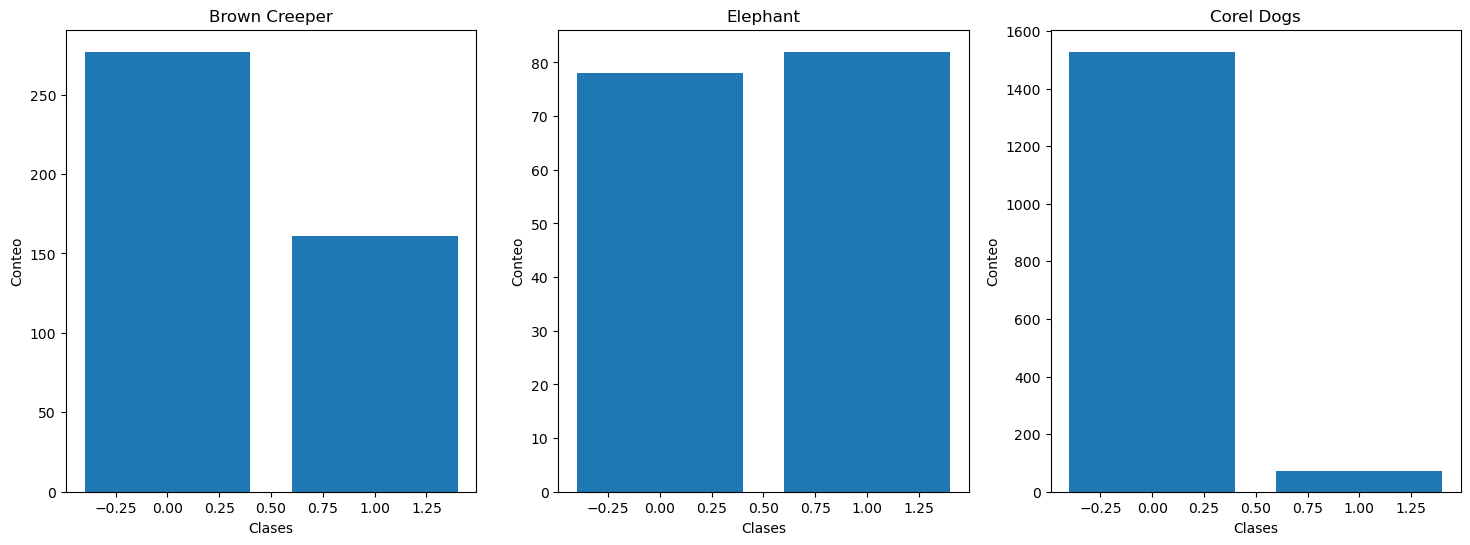

In [10]:
# Train
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(np.unique(yBrownCreeper_train, return_counts=True)[0], np.unique(yBrownCreeper_train, return_counts=True)[1])
ax[0].set_title('Brown Creeper')
ax[0].set_ylabel('Conteo')
ax[0].set_xlabel('Clases')
ax[1].bar(np.unique(yElephant_train, return_counts=True)[0], np.unique(yElephant_train, return_counts=True)[1])
ax[1].set_title('Elephant')
ax[1].set_ylabel('Conteo')
ax[1].set_xlabel('Clases')
ax[2].bar(np.unique(yCorelDogs_train, return_counts=True)[0], np.unique(yCorelDogs_train, return_counts=True)[1])
ax[2].set_title('Corel Dogs')
ax[2].set_ylabel('Conteo')
ax[2].set_xlabel('Clases')
plt.show()

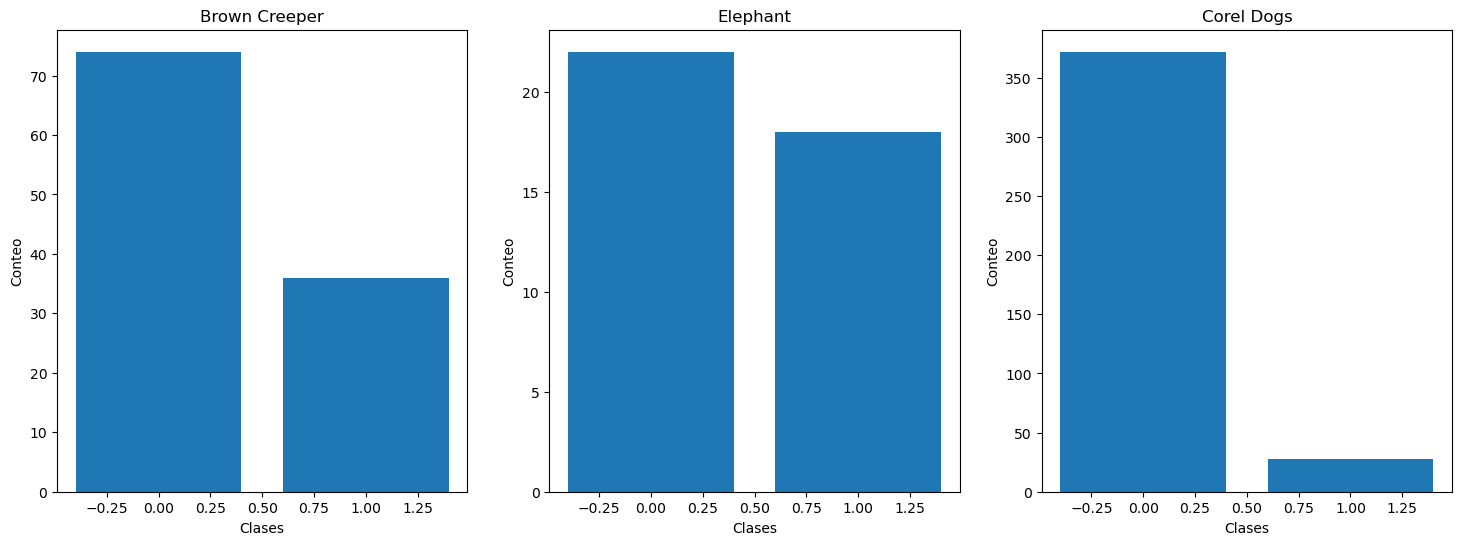

In [11]:
# Test
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(np.unique(yBrownCreeper_test, return_counts=True)[0], np.unique(yBrownCreeper_test, return_counts=True)[1])
ax[0].set_title('Brown Creeper')
ax[0].set_ylabel('Conteo')
ax[0].set_xlabel('Clases')
ax[1].bar(np.unique(yElephant_test, return_counts=True)[0], np.unique(yElephant_test, return_counts=True)[1])
ax[1].set_title('Elephant')
ax[1].set_ylabel('Conteo')
ax[1].set_xlabel('Clases')
ax[2].bar(np.unique(yCorelDogs_test, return_counts=True)[0], np.unique(yCorelDogs_test, return_counts=True)[1])
ax[2].set_title('Corel Dogs')
ax[2].set_ylabel('Conteo')
ax[2].set_xlabel('Clases')
plt.show()

In [6]:
from mil.trainer.trainer import Trainer
from mil.models import MILES, APR, SVM # MILES = Bag Space Method, APR = Instance Space Method
from mil.metrics import Accuracy, Recall, Precision, F1Score

ModuleNotFoundError: No module named 'tensorflow.python'

Queremos tratar un problema de aprendizaje semi-supervisado pero la forma que hemos utilizado para tener los conjuntos de datos de scikit nos los da para un problema supervisado. Por eso se debe simular un conjunto de datos semi-supervisado como indicaba la nota de la práctica, eliminando etiquetas de un porcentaje de instancias

In [26]:
SEMISUPERVISED_ELIMINATE = 0.3

In [27]:
# Dataset Iris
mask_unlabeled = rng.rand(len(Iris_Y)) < SEMISUPERVISED_ELIMINATE # Eliminación de un 30% de las etiquetas
Iris_Y[mask_unlabeled] = -1

# Dataset BreastCancer
mask_unlabeled = rng.rand(len(Wine_Y)) < SEMISUPERVISED_ELIMINATE # Eliminación de un 30% de las etiquetas
Wine_Y[mask_unlabeled] = -1

# Dataset Breast Cancer
mask_unlabeled = rng.rand(len(BreastCancer_Y)) < SEMISUPERVISED_ELIMINATE # Eliminación de un 30% de las etiquetas
BreastCancer_Y[mask_unlabeled] = -1

Ya tenemos el conjunto de datos preparado para aprendizaje semi-supervisado. Pero tenemos el conjunto de datos completo. Al estar trabajando y simulando problemas de *machine learning* debemos realizar una división del dataset en los subconjuntos:
- Train
- Validación
- Test

Pero al estar haciendo simulaciones sólo realizaremos la división en los conjuntos de Train y Test. Normalmente cuando se dividen entre estos subconjuntos la división suele ser del 70-30 o del 80-20. Vamos a probar con un 70-30.

In [28]:
# Dataset Iris
Iris_X_train, Iris_X_test, Iris_Y_train, Iris_Y_test = train_test_split(Iris_X, Iris_Y, test_size=0.3, random_state=SEED)

# Dataset Wine
Wine_X_train, Wine_X_test, Wine_Y_train, Wine_Y_test = train_test_split(Wine_X, Wine_Y, test_size=0.3, random_state=SEED)

# Dataset Breast Cancer
BreastCancer_X_train, BreastCancer_X_test, BreastCancer_Y_train, BreastCancer_Y_test = train_test_split(BreastCancer_X, BreastCancer_Y, test_size=0.3, random_state=SEED)

Se normalizan los datos

In [29]:
# Dataset Iris
scaler = StandardScaler()
X_train = scaler.fit_transform(Iris_X_train)
X_test = scaler.transform(Iris_X_test)

# Dataset Wine
scaler = StandardScaler()
X_train = scaler.fit_transform(Wine_X_train)
X_test = scaler.transform(Wine_X_test)

# Dataset Breast Cancer
scaler = StandardScaler()
X_train = scaler.fit_transform(BreastCancer_X_train)
X_test = scaler.transform(BreastCancer_X_test)

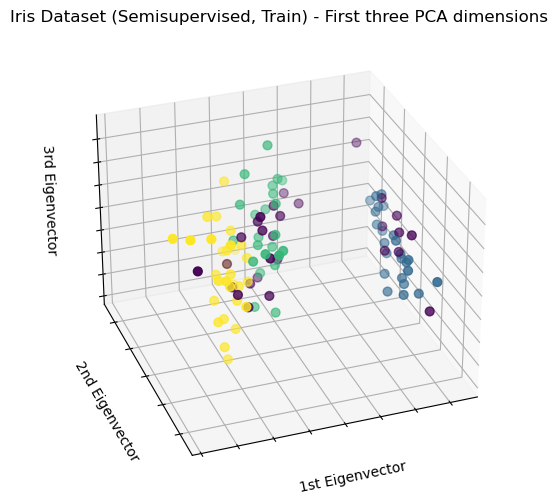

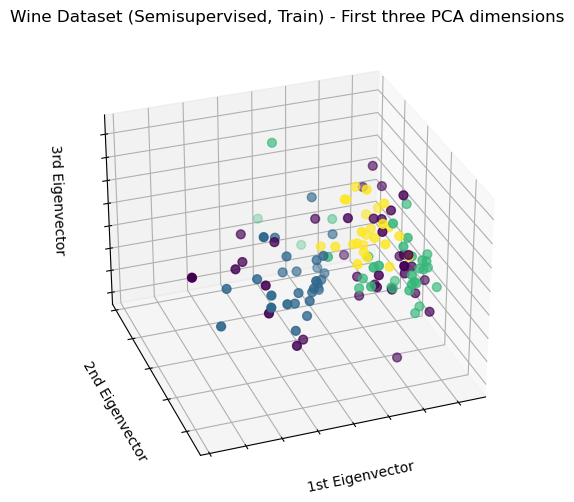

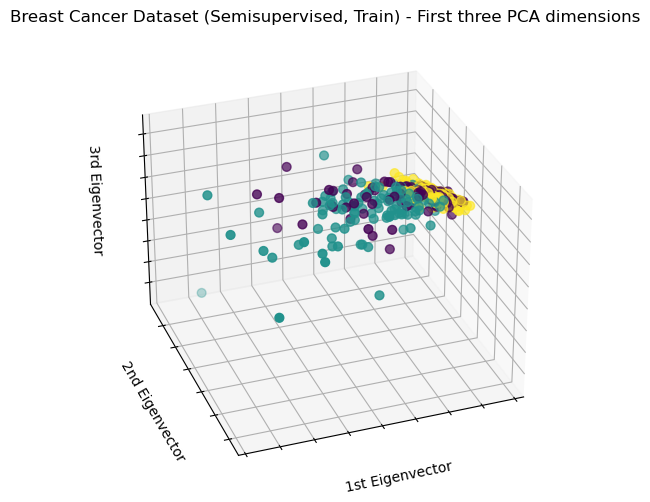

In [30]:
# Iris Dataset
plot_dataset(Iris_X_train, Iris_Y_train, "Iris Dataset (Semisupervised, Train) - First three PCA dimensions")

# Wine Dataset
plot_dataset(Wine_X_train, Wine_Y_train, "Wine Dataset (Semisupervised, Train) - First three PCA dimensions")

# Breast Cancer Dataset
plot_dataset(BreastCancer_X_train, BreastCancer_Y_train, "Breast Cancer Dataset (Semisupervised, Train) - First three PCA dimensions")

Scikit tiene dos algoritmos semi-supervisados ya implementados según la [documentación](https://scikit-learn.org/stable/modules/semi_supervised.html). Así que se usaran estos dos algoritmos:
- Self Training
- Label Propagation

Pero además, revisando los algoritmos implementados en el módulo de semi_supervised hemos encontrado el algoritmo LabelSpreading, así que usaremos estos 3 algoritmos.

Según la documentación Label Propagation y Label Spreading se basan en lo mismo pero: *LabelPropagation and LabelSpreading differ in modifications to the similarity matrix that graph and the clamping effect on the label distributions. Clamping allows the algorithm to change the weight of the true ground labeled data to some degree. The LabelPropagation algorithm performs hard clamping of input labels, which means alpha=0. This clamping factor can be relaxed, to say alpha = 0.2, which means that we will always retain 80 percent of our original label distribution, but the algorithm gets to change its confidence of the distribution within 20 percent.*

In [31]:
# Self Training
svc = SVC(probability=True, gamma="auto")
Iris_self_training_model = SelfTrainingClassifier(svc)
Wine_self_training_model = SelfTrainingClassifier(svc)
BreastCancer_self_training_model = SelfTrainingClassifier(svc)

# Label Propagation
Iris_lp = LabelPropagation(kernel='knn', n_neighbors=7)
Wine_lp = LabelPropagation(kernel='knn', n_neighbors=7)
BreastCancer_lp = LabelPropagation(kernel='knn', n_neighbors=7)

# Label Spreading
Iris_ls = LabelSpreading(kernel='rbf', gamma=0.25)
Wine_ls = LabelSpreading(kernel='rbf', gamma=0.25)
BreastCancer_ls = LabelSpreading(kernel='rbf', gamma=0.25)

### Parte 1: Aplicar algoritmos

Y ahora aplicamos los algoritmos a cada conjunto de datos

In [32]:
# Dataset Iris
Iris_self_training_model.fit(Iris_X_train, Iris_Y_train)
Iris_lp.fit(Iris_X_train, Iris_Y_train)
Iris_ls.fit(Iris_X_train, Iris_Y_train)

# Dataset Wine
Wine_self_training_model.fit(Wine_X_train, Wine_Y_train)
Wine_lp.fit(Wine_X_train, Wine_Y_train)
Wine_ls.fit(Wine_X_train, Wine_Y_train)

# Dataset Breast Cancer
BreastCancer_self_training_model.fit(BreastCancer_X_train, BreastCancer_Y_train)
BreastCancer_lp.fit(BreastCancer_X_train, BreastCancer_Y_train)
BreastCancer_ls.fit(BreastCancer_X_train, BreastCancer_Y_train)

LabelSpreading(gamma=0.25)

Calcular las predicciones en el conjunto de pruebas (test):

In [33]:
# Dataset Iris
Iris_st_predictions = Iris_self_training_model.predict(Iris_X_test)
Iris_lp_predictions = Iris_lp.predict(Iris_X_test)
Iris_ls_predictions = Iris_ls.predict(Iris_X_test)

# Dataset Wine
Wine_st_predictions = Wine_self_training_model.predict(Wine_X_test)
Wine_lp_predictions = Wine_lp.predict(Wine_X_test)
Wine_ls_predictions = Wine_ls.predict(Wine_X_test)

# Dataset Breast Cancer
BreastCancer_st_predictions = BreastCancer_self_training_model.predict(BreastCancer_X_test)
BreastCancer_lp_predictions = BreastCancer_lp.predict(BreastCancer_X_test)
BreastCancer_ls_predictions = BreastCancer_ls.predict(BreastCancer_X_test)

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


### Métricas

Se evalua la precisión de los modelos

#### Matriz de confusión

In [34]:
# Dataset Iris
Iris_st_cm = confusion_matrix(Iris_Y_test, Iris_st_predictions)
Iris_lp_cm = confusion_matrix(Iris_Y_test, Iris_lp_predictions)
Iris_ls_cm = confusion_matrix(Iris_Y_test, Iris_ls_predictions)

# Dataset Wine
Wine_st_cm = confusion_matrix(Wine_Y_test, Wine_st_predictions)
Wine_lp_cm = confusion_matrix(Wine_Y_test, Wine_lp_predictions)
Wine_ls_cm = confusion_matrix(Wine_Y_test, Wine_ls_predictions)

# Dataset Breast Cancer
BreastCancer_st_cm = confusion_matrix(BreastCancer_Y_test, BreastCancer_st_predictions)
BreastCancer_lp_cm = confusion_matrix(BreastCancer_Y_test, BreastCancer_lp_predictions)
BreastCancer_ls_cm = confusion_matrix(BreastCancer_Y_test, BreastCancer_st_predictions)

#### Accuracy

In [35]:
# Dataset Iris
Iris_st_accuracy = accuracy_score(Iris_Y_test, Iris_st_predictions)
Iris_lp_accuracy = accuracy_score(Iris_Y_test, Iris_lp_predictions)
Iris_ls_accuracy = accuracy_score(Iris_Y_test, Iris_ls_predictions)

# Dataset Wine
Wine_st_accuracy = accuracy_score(Wine_Y_test, Wine_st_predictions)
Wine_lp_accuracy = accuracy_score(Wine_Y_test, Wine_lp_predictions)
Wine_ls_accuracy = accuracy_score(Wine_Y_test, Wine_ls_predictions)

# Dataset Breast Cancer
BreastCancer_st_accuracy = accuracy_score(BreastCancer_Y_test, BreastCancer_st_predictions)
BreastCancer_lp_accuracy = accuracy_score(BreastCancer_Y_test, BreastCancer_lp_predictions)
BreastCancer_ls_accuracy = accuracy_score(BreastCancer_Y_test, BreastCancer_st_predictions)

#### Precisión

Las siguientes métricas tienen el parámetro average con el valor predeterminado 'binary', que está diseñado para problemas de clasificación binaria. Pero los problemas son de clasificación multiclase. La solución es especificar el parámetro average como 'weighted' o 'micro'

In [36]:
# Dataset Iris
Iris_st_precision = precision_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_precision = precision_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_ls_precision = precision_score(Iris_Y_test, Iris_ls_predictions, average='weighted')

# Dataset Wine
Wine_st_precision = precision_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_precision = precision_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_ls_precision = precision_score(Wine_Y_test, Wine_ls_predictions, average='weighted')

# Dataset Breast Cancer
BreastCancer_st_precision = precision_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
BreastCancer_lp_precision = precision_score(BreastCancer_Y_test, BreastCancer_lp_predictions, average='weighted')
BreastCancer_ls_precision = precision_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\albam\anaconda3\envs\M

#### Recall

In [37]:
# Dataset Iris
Iris_st_recall = recall_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_recall = recall_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_ls_recall = recall_score(Iris_Y_test, Iris_ls_predictions, average='weighted')

# Dataset Wine
Wine_st_recall = recall_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_recall = recall_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_ls_recall = recall_score(Wine_Y_test, Wine_ls_predictions, average='weighted')

# Dataset Breast Cancer
BreastCancer_st_recall = recall_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
BreastCancer_lp_recall = recall_score(BreastCancer_Y_test, BreastCancer_lp_predictions, average='weighted')
BreastCancer_ls_recall = recall_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')

#### F1 Score

In [38]:
# Dataset Iris
Iris_st_f1 = f1_score(Iris_Y_test, Iris_st_predictions, average='weighted')
Iris_lp_f1 = f1_score(Iris_Y_test, Iris_lp_predictions, average='weighted')
Iris_ls_f1 = f1_score(Iris_Y_test, Iris_ls_predictions, average='weighted')

# Dataset Wine
Wine_st_f1 = f1_score(Wine_Y_test, Wine_st_predictions, average='weighted')
Wine_lp_f1 = f1_score(Wine_Y_test, Wine_lp_predictions, average='weighted')
Wine_ls_f1 = f1_score(Wine_Y_test, Wine_ls_predictions, average='weighted')

# Dataset Breast Cancer
BreastCancer_st_f1 = f1_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')
BreastCancer_lp_f1 = f1_score(BreastCancer_Y_test, BreastCancer_lp_predictions, average='weighted')
BreastCancer_ls_f1 = f1_score(BreastCancer_Y_test, BreastCancer_st_predictions, average='weighted')


### Muestra de resultados

Se han ejecutado varias veces el código cambiando la cantidad de etiquetas eliminadas, empezando por un 90% (el más inferior), luego un 50%, y por último un 30%, que son los primeros resultados que se pueden ver

In [39]:
def print_metrics(dataset_name, algorithm_name, cm, accuracy, precision, recall, f1):
    print(f"\nMetricas para {algorithm_name} en el dataset {dataset_name}:")
    print("Matriz de Confusión:")
    print(cm)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precisión: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n\n")

Resultados eliminando un 30% de las etiquetas

In [40]:
# Print metrics for Iris dataset
print_metrics("Iris", "Self Training", Iris_st_cm, Iris_st_accuracy, Iris_st_precision, Iris_st_recall, Iris_st_f1)
print_metrics("Iris", "Label Propagation", Iris_lp_cm, Iris_lp_accuracy, Iris_lp_precision, Iris_lp_recall, Iris_lp_f1)
print_metrics("Iris", "Label Spreading", Iris_ls_cm, Iris_ls_accuracy, Iris_ls_precision, Iris_ls_recall, Iris_ls_f1)


Metricas para Self Training en el dataset Iris:
Matriz de Confusión:
[[ 0  4  2  6]
 [ 0 13  0  0]
 [ 0  0 13  0]
 [ 0  0  0  7]]
Accuracy: 0.7333
Precisión: 0.5550
Recall: 0.7333
F1 Score: 0.6275




Metricas para Label Propagation en el dataset Iris:
Matriz de Confusión:
[[ 0  4  2  6]
 [ 0 13  0  0]
 [ 0  0 13  0]
 [ 0  0  0  7]]
Accuracy: 0.7333
Precisión: 0.5550
Recall: 0.7333
F1 Score: 0.6275




Metricas para Label Spreading en el dataset Iris:
Matriz de Confusión:
[[ 0  4  0  8]
 [ 0 13  0  0]
 [ 0  0 10  3]
 [ 0  0  0  7]]
Accuracy: 0.6667
Precisión: 0.5703
Recall: 0.6667
F1 Score: 0.5887





# Datasets tras eliminar el 30% de las etiquetas

## Iris

### Self Training:
- **Matriz de Confusión:** La matriz de confusión muestra una tendencia a clasificar correctamente las clases 1 y 2 pero las clases 0 y 3 presentan un número significativo de falsos positivos y falsos negativos. Siendo la clase 0 la que más confusión presenta al no tener ningún Verdadero Positivo.
- **Métricas:** El valor del *accuracy* es del 73.33%, lo que indica un rendimiento aceptable en la clasificación. Superior al 50% que indicaría una clasificación aleatoria. El *recall* tiene el mismo valor mientras que la precisión es más baja. Esto quiere decir que el modelo tiende a ser más sensible a la detección de casos positivos, pero puede haber más falsos positivos en comparación con los verdaderos positivos, es decir, que el modelo tiene dificultades para evitar falsos positivos.
- **F1 Score:** El valor F1 Score, que combina precisión y recall, es 0.6275, indicando una puntuación aceptable, pero aún mejorable.

### Label Propagation:
- **Matriz de Confusión:** La matriz de confusión es idéntica a la obtenida con Self Training, indicando similitud en la clasificación entre ambos algoritmos.
- **Métricas:** Los valores son iguales a los obtenidos con Self Training, lo que sugiere un funcionamiento similar en el rendimiento entre ambos algoritmos en este caso.

### Label Spreading:
- **Matriz de Confusión:** Muestra una mayor confusión en la clasificación, especialmente en la clase 0. La clase 2 y 3 también experimentan cierta dificultad en la clasificación.
- **Accuracy:** Aunque la precisión general es ligeramente menor (66.67%) en comparación con los otros dos algoritmos, sigue siendo aceptable.
- **Precisión y Recall:** La precisión mejora respecto a los algoritmos anteriores pero mínimamente, mientras que el recall es más bajo aunque la diferencia también es pequeña, indicando que el modelo tiende a clasificar correctamente las clases de manera más precisa, pero puede perder algunos ejemplos de las clase.
- **F1 Score:** El F1 Score (0.5887) es inferior a los obtenidos con Self Training y Label Propagation, sugiriendo que, en este caso, Label Spreading puede no ser la mejor opción.

En resumen, los tres algoritmos muestran un rendimiento similar en el dataset Iris después de la eliminación del 30% de las etiquetas. La elección entre ellos puede depender de las necesidades específicas del problema y de la importancia relativa de precisiones y recalls para las diferentes clases.

In [41]:
# Print metrics for Wine dataset
print_metrics("Wine", "Self Training", Wine_st_cm, Wine_st_accuracy, Wine_st_precision, Wine_st_recall, Wine_st_f1)
print_metrics("Wine", "Label Propagation", Wine_lp_cm, Wine_lp_accuracy, Wine_lp_precision, Wine_lp_recall, Wine_lp_f1)
print_metrics("Wine", "Label Spreading", Wine_ls_cm, Wine_ls_accuracy, Wine_ls_precision, Wine_ls_recall, Wine_ls_f1)


Metricas para Self Training en el dataset Wine:
Matriz de Confusión:
[[ 0  1 10  0]
 [ 0  2 14  0]
 [ 0  0 14  0]
 [ 0  0 12  1]]
Accuracy: 0.3148
Precisión: 0.5109
Recall: 0.3148
F1 Score: 0.2102




Metricas para Label Propagation en el dataset Wine:
Matriz de Confusión:
[[ 0  5  3  3]
 [ 0 15  0  1]
 [ 0  1 11  2]
 [ 0  2  4  7]]
Accuracy: 0.6111
Precisión: 0.4813
Recall: 0.6111
F1 Score: 0.5358




Metricas para Label Spreading en el dataset Wine:
Matriz de Confusión:
[[ 0  5  4  2]
 [ 0 14  0  2]
 [ 0  1 11  2]
 [ 0  1  4  8]]
Accuracy: 0.6111
Precisión: 0.4852
Recall: 0.6111
F1 Score: 0.5397





## Wine

### Self Training:
- **Matriz de Confusión:** Muestra cierta confusión en la clasificación, especialmente en las clases 0 y 3.
- **Métricas** Todas las métricas tienen valores bastante bajos.

### Label Propagation:
- **Matriz de Confusión:** Muestra una pequeña mejora en la clasificación en comparación con Self Training.
- **Accuracy:** La precisión general ha mejorado significativamente (61.11%), indicando un rendimiento más sólido respecto al algoritmo anterior.
- **Precisión y Recall:** Ambos valores son bastante bajos para ser considerados aceptables aunque mejoran los resultados del algoritmo anterior, F1 Score (0.5358) indica una mejora en la calidad del modelo en comparación con Self Training.

### Label Spreading:
- **Matriz de Confusión:** Muestra resultados similares a Label Propagation.
- **Métricas:** Los valores son muy similares a los del algoritmo anterior por lo que se puede intuir que el funcionamiento de ambos algoritmos es similar cuando faltan más etiquetas.

### Comparación con Resultados Anteriores:
- En el dataset Wine, los modelos muestran un rendimiento más sólido en comparación con los resultados obtenidos en el dataset Iris.
- La eliminación del 30% de las etiquetas ha afectado de manera diferente a cada algoritmo en este conjunto de datos.
- Label Propagation es el algoritmo con mejor desempeño para ambos datasets. En ambos casos hay 2 algoritmos con resultados similares pero es Label Propagation el que obtiene buenos resultados en ambos *datasets*.

In [42]:
# Print metrics for Breast Cancer dataset
print_metrics("Breast Cancer", "Self Training", BreastCancer_st_cm, BreastCancer_st_accuracy, BreastCancer_st_precision, BreastCancer_st_recall, BreastCancer_st_f1)
print_metrics("Breast Cancer", "Label Propagation", BreastCancer_lp_cm, BreastCancer_lp_accuracy, BreastCancer_lp_precision, BreastCancer_lp_recall, BreastCancer_lp_f1)
print_metrics("Breast Cancer", "Label Spreading", BreastCancer_ls_cm, BreastCancer_ls_accuracy, BreastCancer_ls_precision, BreastCancer_ls_recall, BreastCancer_ls_f1)


Metricas para Self Training en el dataset Breast Cancer:
Matriz de Confusión:
[[ 0  0 58]
 [ 0  0 39]
 [ 0  0 74]]
Accuracy: 0.4327
Precisión: 0.1873
Recall: 0.4327
F1 Score: 0.2614




Metricas para Label Propagation en el dataset Breast Cancer:
Matriz de Confusión:
[[ 0 19 39]
 [ 0 34  5]
 [ 0  2 72]]
Accuracy: 0.6199
Precisión: 0.4096
Recall: 0.6199
F1 Score: 0.4930




Metricas para Label Spreading en el dataset Breast Cancer:
Matriz de Confusión:
[[ 0  0 58]
 [ 0  0 39]
 [ 0  0 74]]
Accuracy: 0.4327
Precisión: 0.1873
Recall: 0.4327
F1 Score: 0.2614





## Breast Cancer

### Self Training:
- **Matriz de Confusión:** Muestra una clasificación concentrada en la clase 2, con una alta proporción de falsos positivos y falsos negativos.
- **M´tricas:** Todas tienen valores bastante bajos.

### Label Propagation:
- **Matriz de Confusión:** Muestra una mejora en la clasificación en comparación con Self Training, con una distribución más equitativa de falsos positivos y negativos.
- **Accuracy:** El accuracy general ha mejorado significativamente (61.99%), indicando un mejor rendimiento.
- **Métricas:** Aún así los valores de las métricas siguen siendo bastante bajos.

### Label Spreading:
- **Matriz de Confusión:** Muestra resultados idénticos a Self Training, indicando que ambos algoritmos tienen un funcionamiento similar
- **Métricas:** Al ser idéntica la matriz también lo son las métricas.


- En el dataset Breast Cancer, Label Propagation muestra un rendimiento significativamente superior a Self Training después de la eliminación del 30% de las etiquetas.
- Label Spreading produce resultados idénticos a Self Training en este escenario.

### Comparación con Resultados Anteriores:
- Label Propagation sigue siendo el algoritmo con mejor rendimiento para cualquiera de los 3 conjuntos de datos.